In [68]:
# Importing libraries and setting up the project
import urllib2
from requests import get
from IPython.core.display import clear_output
from warnings import warn
from bs4 import BeautifulSoup
from time import time, sleep
from random import randint
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt

In [2]:
# Function declarations

# Get and clean the name of an item
def get_name(item):

    name = str(item.span.text.strip())
    has_volume_b = has_volume(item)

    if has_volume_b:
        volume = get_volume(item)
        if volume < 100:
            final_index = len(name) - 5
            new_name = name[:final_index]
            if new_name[-1] == " ":
                new_name = new_name[:-1]
            elif new_name[-1] == "-":
                new_name = new_name[:-1]
                if new_name[-1] == " ":
                    new_name = new_name[:-1]
            return str(new_name)
        elif volume >= 100:
            final_index = len(name) - 6
            new_name = name[:final_index]
            if new_name[-1] == " ":
                new_name = new_name[:-1]
            elif new_name[-1] == "-":
                new_name = new_name[:-1]
                if new_name[-1] == " ":
                    new_name = new_name[:-1]
            return str(new_name)
        
    else:
        return str(name)

    
# Determines if an item has a volume in its name
def has_volume(item):
    
    item_name = item.span.text.strip()
    regex_1 = r"\d+"
    contains_vol = re.compile(regex_1)
    volume_list = contains_vol.findall(item_name)

    if len(volume_list) == 0:
        return False

    else:
        return True

# Determines if an item has volume, regardless of if we know it has a volume or not
def get_volume(item):
    
    name = item.span.text.strip()
    has_volume_bool = has_volume(item)
    
    if has_volume_bool:
        item_name = item.span.text.strip()
        regex_1 = r"\d+"
        contains_vol = re.compile(regex_1)
        volume_list = contains_vol.findall(item_name)
        
        volume = int(volume_list[0])
        return volume
    
    else:
        return None
    
# Determines the material an item is made out of
def get_material(item):
    
    item_name = item.span.text.strip()
    material_list = [r"Ruyao", r"Celadon", r"Glass", r"Clay", r"Porcelain"]

    for s in material_list:
        
        material_container = re.compile(s)
        list_of_truth = material_container.findall(item_name)

        if len(list_of_truth) != 0:
            material = list_of_truth[0]
            return str(material)
        
    return None

# Determines the price of an item
def get_price(item):
    
    raw_price = item.find("span", class_ = "price ")
    
    if raw_price is not None:
        price = item.find("span", class_ = "price ").span.text.strip()
        
        if str(price) != "Sold Out":
            price = float(price[1:])
            return price
        
        else:
            return None
        
    else:
        price = item.find("span", class_ = "was_price").text.strip()
        price = float(price[1:])
        return price

In [3]:
# Project starts here
# Scraping information about gaiwans from Teaware.House
# Loading all the names and prices from the gaiwan_box into lists

name_list = []
price_list = []
volume_list = []
material_list = []

# Preparing the monitoring of the loop
start_time = time()
requests = 0
pages = range(1,3)

# For every page of products
for page in pages:

    # Make a get request
    response = get("https://teaware.house/collections/gaiwan?page=" + str(page))

    # Pause the loop
    sleep(randint(8,15))

    # Monitor the requests
    requests += 1
    elapsed_time = time() - start_time
    print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
    clear_output(wait = True)

    # Throw a warning for non-200 status codes
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))

    # Break the loop if the number of requests is greater than expected
    if requests > 72:
        warn('Number of requests was greater than expected.')  
        break 

    # Parse the content of the request with BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    gaiwan_box = soup.find_all("div", attrs={"class": "info"})
    for gaiwan in gaiwan_box:
        
        # Get name
        name = get_name(gaiwan)
        name_list.append(name)
        
        # Get price
        price = get_price(gaiwan)
        price_list.append(price)
        
        # Get volume
        volume = get_volume(gaiwan)
        volume_list.append(volume)
        
        # Get material
        material = get_material(gaiwan)
        material_list.append(material)
        

Request:2; Frequency: 0.0798364313105 requests/s


In [4]:
# Project continues
# Gaiwans from Teaware.House continued

# Throwing the lists into a data frame and seeing if it worked
twh_gaiwan_df = pd.DataFrame({"Name": name_list, "Price": price_list, "Volume": volume_list, "Material": material_list})
twh_gaiwan_df.insert(1, "Item", "Gaiwan")
twh_gaiwan_df["Vendor"] = "Teaware.House"

# Removing select values from the df
twh_gaiwan_df = twh_gaiwan_df[~twh_gaiwan_df["Name"].str.contains("Bag")]
twh_gaiwan_df = twh_gaiwan_df[~twh_gaiwan_df["Name"].str.contains("Mat Set")]
twh_gaiwan_df = twh_gaiwan_df[~twh_gaiwan_df["Name"].str.contains("Lid")]

print(twh_gaiwan_df.info())
twh_gaiwan_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 64
Data columns (total 6 columns):
Material    43 non-null object
Item        63 non-null object
Name        63 non-null object
Price       43 non-null float64
Volume      58 non-null float64
Vendor      63 non-null object
dtypes: float64(2), object(4)
memory usage: 3.4+ KB
None


,Material,Item,Name,Price,Volume,Vendor
0,None,Gaiwan,Antique Style Ju Flower Tea Gaiwan,19.99,140.0,Teaware.House
1,None,Gaiwan,Antique Style Ju Wave Tea Gaiwan,NaN,140.0,Teaware.House
2,None,Gaiwan,Art of War Thirty Six Stratagems Gaiwan,14.99,145.0,Teaware.House
3,Porcelain,Gaiwan,Big Blue Bouquet Porcelain Gaiwan,21.99,300.0,Teaware.House
4,Porcelain,Gaiwan,Big Hidden Temple Porcelain Gaiwan,21.99,300.0,Teaware.House
5,Porcelain,Gaiwan,Big Pink Peony Porcelain Gaiwan,21.99,300.0,Teaware.House
6,Ruyao,Gaiwan,Blue Blessing Lotus Ruyao Gaiwan,39.99,160.0,Teaware.House
7,Ruyao,Gaiwan,Blue Blessing Ruyao Gaiwan,29.99,115.0,Teaware.House
8,None,Gaiwan,Blue Lotus Gray Geyao Gaiwan,19.99,100.0,Teaware.House
9,None,Gaiwan,Buddhist Heart Sutra Gaiwan,14.99,145.0,Teaware.House


In [5]:
# Project continues
# Repeating the process. Scraping info about teapots from Teaware.House
# Loading all the names and prices from the teapot_box into lists

name_list = []
price_list = []
volume_list = []
material_list = []

# Preparing the monitoring of the loop
start_time_2 = time()
requests = 0
pages = range(1,3)
vol_count = 1

# For every page of products
for page in pages:

    # Make a get request
    response = get("https://teaware.house/collections/teapots?page=" + str(page))

    # Pause the loop
    sleep(randint(8,15))

    # Monitor the requests
    requests += 1
    elapsed_time = time() - start_time_2
    print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
    clear_output(wait = True)

    # Throw a warning for non-200 status codes
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))

    # Break the loop if the number of requests is greater than expected
    if requests > 72:
        warn('Number of requests was greater than expected.')  
        break 

    # Parse the content of the request with BeautifulSoup
    teapot_soup = BeautifulSoup(response.text, 'html.parser')
    teapot_box = teapot_soup.find_all("div", attrs={"class": "info"})
    for teapot in teapot_box:
        
        # Get name
        name = get_name(teapot)
        name_list.append(name)
        
        # Get price
        price = get_price(teapot)
        price_list.append(price)
        
        # Get volume
        volume = get_volume(teapot)
        volume_list.append(volume)
        
        # Get material
        material = get_material(teapot)
        material_list.append(material)

Request:2; Frequency: 0.111426434866 requests/s


In [6]:
# Project continues

# Loading data from teapot scraping into a data frame to see what happened
twh_teapot_df = pd.DataFrame({"Name": name_list, "Price": price_list, "Volume": volume_list, "Material": material_list})

# Adding columns for "Item" and "Vendor"
twh_teapot_df.insert(1, "Item", "Teapot")
twh_teapot_df["Vendor"] = "Teaware.House"

# Removing select values from the df
twh_teapot_df = twh_teapot_df[~twh_teapot_df["Name"].str.contains("Bag")]
twh_teapot_df = twh_teapot_df[~twh_teapot_df["Name"].str.contains("Mat Set")]
twh_teapot_df = twh_teapot_df[~twh_teapot_df["Name"].str.contains("Lid")]

print(twh_teapot_df.info())
twh_teapot_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 60
Data columns (total 6 columns):
Material    39 non-null object
Item        55 non-null object
Name        55 non-null object
Price       42 non-null float64
Volume      51 non-null float64
Vendor      55 non-null object
dtypes: float64(2), object(4)
memory usage: 3.0+ KB
None


,Material,Item,Name,Price,Volume,Vendor
0,None,Teapot,Antique Style Peony Teapot,NaN,NaN,Teaware.House
1,None,Teapot,Antique Style Poppy Teapot,NaN,NaN,Teaware.House
2,None,Teapot,Antique Style Sunflower Teapot,NaN,NaN,Teaware.House
3,Ruyao,Teapot,Aurora Ruyao Pot Still Kyusu Artisan Teapot,99.99,190.0,Teaware.House
5,Ruyao,Teapot,Azure Ruyao Square Teapot,29.99,230.0,Teaware.House
6,Ruyao,Teapot,Azure Ruyao Tall Teapot,29.99,220.0,Teaware.House
7,Ruyao,Teapot,Azure Ruyao Three-footed Teapot,NaN,180.0,Teaware.House
8,Ruyao,Teapot,Azure Ruyao Xishi Teapot,29.99,180.0,Teaware.House
9,None,Teapot,Blue Blessing Cloud Arch Teapot,NaN,150.0,Teaware.House
10,None,Teapot,Blue Blessing Tilting Bamboo Teapot,29.99,150.0,Teaware.House


In [7]:
# Gaiwan df max and min
twh_gaiwan_df.describe().loc[['min', 'max'], ['Price', 'Volume']]

,Price,Volume
min,9.99,50.0
max,39.99,300.0


In [8]:
# Teapot df max and min
twh_teapot_df.describe().loc[['min', 'max'], ['Price', 'Volume']]

,Price,Volume
min,9.99,100.0
max,124.99,250.0


In [9]:
# Median, mean, and mode of gaiwan df
median_gaiwan = twh_gaiwan_df.Price.median()
mean_gaiwan = twh_gaiwan_df.Price.mean()
mode_gaiwan = twh_gaiwan_df.Price.mode()
print("Median gaiwan price: " + str(median_gaiwan))
print("Mean gaiwan price: " + str(mean_gaiwan))
print("Mode gaiwan price: " + str(mode_gaiwan))

# Median, mean, and mode of teapot df
median_teapot = twh_teapot_df.Price.median()
mean_teapot = twh_teapot_df.Price.mean()
mode_teapot = twh_teapot_df.Price.mode()
print("\nMedian teapot price: " + str(median_teapot))
print("Mean teapot price: " + str(mean_teapot))
print("Mode teapot price: " + str(mode_teapot))

Median gaiwan price: 19.99
Mean gaiwan price: 21.2690697674
Mode gaiwan price: 0    14.99
dtype: float64

Median teapot price: 24.99
Mean teapot price: 35.9066666667
Mode teapot price: 0    19.99
dtype: float64


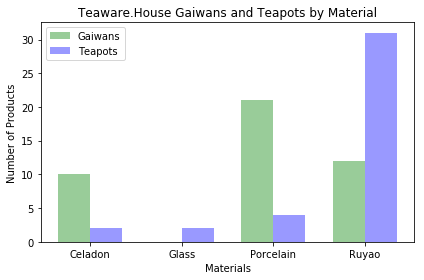

In [84]:
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

gaiwan_material = twh_gaiwan_df[twh_gaiwan_df["Material"].notnull()]
teapot_material = twh_teapot_df[twh_teapot_df["Material"].notnull()]

gaiwan_group = twh_gaiwan_df.groupby("Material").Name.count().reset_index()
glist = gaiwan_group.Name.tolist()
glist_label = gaiwan_group.Material.tolist()

teapot_group = twh_teapot_df.groupby("Material").Name.count().reset_index()
tlist = teapot_group.Name.tolist()
tlist_label = teapot_group.Material.tolist()

glist.insert(1, 0)
glist_label.insert(1, "Glass")

gtuple = tuple(glist)
ttuple = tuple(tlist)

n_groups = 4
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.4

rects1 = ax.bar(index, gtuple, bar_width,
                alpha=opacity, color='g', label='Gaiwans')

rects2 = ax.bar(index + bar_width, ttuple, bar_width,
                alpha=opacity, color='b', label='Teapots')

ax.set_xlabel('Materials')
ax.set_ylabel('Number of Products')
ax.set_title('Teaware.House Gaiwans and Teapots by Material')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(tlist_label)
plt.legend()

fig.tight_layout()
plt.show()